# Cusp-capturing PINN - Example 1

* level set augmentation: $\phi$
* activation function: sigmoid

### Import packages

In [1]:
import torch
import torch.nn as nn
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import functools
from pyDOE import lhs

from functorch import make_functional, vmap, grad, jacrev, hessian

from collections import namedtuple, OrderedDict
import datetime
import time
from IPython.display import clear_output 

import warnings
warnings.filterwarnings('ignore')

### Empty cache and check devices 

In [2]:
torch.cuda.empty_cache()
torch.set_default_dtype(torch.float64)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device = ', device)

device =  cpu


### Pre-setup

In [3]:
# domain [a,b]\times[c,d]
bda = 0.
bdb = 1.
# interface position
gma = 1./3.
# beta
btao = 1.
btai = 1.
bta_jmp = btao - btai
bta_avg = 0.5*( btao + btai )
# Network size
n_input  = 2
n_hidden = 2
n_output = 1
n_depth = 1 # only used in deep NN
# tolerence for LM
tol_main    = 10**(-11)
tol_machine = 10**(-15)
mu_max      = 10**8
mu_ini      = 10**8
mu_div      = 1.3
mu_mul      = 2.
# iteration counts and check
tr_iter_max    = 1000                      # max. iteration
ts_input_new   = 500                       # renew testing points 
ls_check       = 500
ls_check0      = ls_check - 1
# number of training points and testing points
c_addpt = 1.
M0 = 10
N_trd = int(1*M0) 
N_trb = 2
N_trg = 1
N_tsd_final = 1000 #100*N_trd
N_tsg_final = 1   #10*N_trg
# create names for storages
fname = 'test' 
char_id = 'a' 

### Exact solution, level set function, and right-hand-side

In [4]:
def levfun(opt, x):
    qo = x - gma
    if opt == 0:
        q = np.copy(qo)
        for i in range(len(qo)):
            if qo[i] < 0.:
                q[i] = -qo[i]  # remove the minus sign when continuous augmented input used
    else:
        q = np.zeros( (len(x),4) )
        q[:,0:1] = qo
        q[:,1:2] = 1.
        q[:,3:4] = 0.
        for i in range(len(x)):
            if qo[i] < 0.:
                q[i,:] = - q[i,:]  # remove the minus sign when continuous augmented input used
        q[:,2:3] = q[:,1:2] * q[:,1:2]
    return q, qo


def lvnorvec(x):
    qnor = 1.
    return qnor


# exact solution of example 01 and 02
def exact_u(x, z):
    eu = np.zeros_like(z)
    gma_0 = gma - 1
    for i in range(len(z)):
        if z[i] >= 0.:
            eu[i] = gma*( x[i] - bdb )
        else:
            eu[i] = gma_0*( x[i] - bda )
    return eu

# normal derivative jump of level set function
def jump_lvdn(x):
    qdn_jmp = 2*np.ones_like(x)  
    # set to zero when continuous augmented input used
    # qdn_jmp = np.zeros_like(x)  
    return qdn_jmp


# normal derivative jump condition along interface: [\beta\partial_n u]=1 
def jump_btadun(x):
    dun = np.ones_like(x)
    return dun


# source
def lapu(x, z):
    ef = np.zeros_like(z)
    return ef

### Define networks: Shallow and Deep

In [5]:
class NeuralNet_Shallow(torch.nn.Module):
    
    ### in_dim: dimension of input; h_dim: number of neurons; out_dim: dimension of output
    
    def __init__(self, in_dim , h_dim , out_dim):
        super(NeuralNet_Shallow, self).__init__()
        self.ln1 = nn.Linear( in_dim , h_dim )
        self.act1 =nn.Sigmoid()
        #self.act1 =nn.ReLU()
        self.ln2 = nn.Linear( h_dim , out_dim , bias=False )
        
    def forward(self, x):
        out = self.ln1(x)
        out = self.act1(out)
        out = self.ln2(out)
        return out

In [6]:
class NeuralNet_Deep(torch.nn.Module):
    
    ### in_dim: dimension of input; h_dim: number of neurons; out_dim: dimension of output
    ### depth: depth of the network
    def __init__(self, in_dim , h_dim , out_dim , depth ):
        super(NeuralNet_Deep, self).__init__()
        self.depth = depth - 1
        self.list  = nn.ModuleList()
        self.ln1   = nn.Linear( in_dim , h_dim )
        self.act1 =nn.Sigmoid()
        #self.act1 =nn.ReLU()
        
        for i in range(self.depth):
            self.list.append( nn.Linear( h_dim , h_dim ) )
        
        self.lnd = nn.Linear( h_dim , out_dim , bias=False )
        
    def forward(self, x):
        out = self.ln1(x)
        out = self.act1(out)
        for i in range(self.depth):
            out = self.list[i](out)
            out = self.act1(out)
        out = self.lnd(out)
        return out

### Essential namedtuples in the model

In [7]:
DataInput = namedtuple( "DataInput" , [ "Xd" , "Phid" , "Fd" , "Xb" , "Ub" , "Xg" , "Fdng" , "NL" , "NL_sqrt"] )
LM_Setup  = namedtuple( "LM_Setup" , [ 'p_vec_o' , 'dp_o' , 'L_o' , 'J_o' , 'mu0' , 'criterion' ] )

### Data generator

In [8]:
def generate_data(iopt, Nd):
    
    ## Xd: points inside the domain (randomly)
    sampling = lhs(n_input-1, Nd)
    xd = bda + (bdb-bda)*sampling[:,0:1]
    Phid, zo = levfun(1, xd)
    # remove points at the interface
    zid  = np.where(np.abs(zo)<5e-16)
    Phid = np.delete(Phid, zid[0], 0)
    xd   = np.delete(xd, zid[0], 0)
    zo   = np.delete(zo, zid[0], 0)    
    # torch tensor and requires_grad
    Xd = np.hstack( ( xd , Phid[:,0:1] ) )
    Xd = torch.tensor(Xd, requires_grad=True).double().to(device)
    Phid = torch.tensor(Phid).double().to(device)
    # right hand side
    Fd = torch.tensor( lapu(xd, zo) ).double().to(device)

    ## Xb: points at the boundary
    xb = np.vstack( ( bda , bdb ) )
    z, zo = levfun(0, xb)
    # Boundary condition
    Ub = exact_u( xb , zo)
    Xb = np.hstack( ( xb , z ) )
    # torch tensor and require grad
    Xb = torch.tensor(Xb, requires_grad=True).double().to(device)
    Ub = torch.tensor(Ub).double().to(device)
       
    ## X_gma: points on the interface N_trg
    xg = gma
    z  = np.zeros_like(xg)
    Xg = np.hstack( ( xg , z ) )
    Xg = torch.tensor(Xg, requires_grad=True).double().to(device)
    # normal vector along the interface
    Xnor_gm = lvnorvec(xg)
    # normal derivative jump condition for level function
    Qdn_gm  = jump_lvdn(xg)
    # normal derivative jump condition for u
    Udn_gm  = jump_btadun(xg)     
    # combine and torch tensor
    Fdng = torch.tensor( np.hstack( ( Xnor_gm , Qdn_gm , Udn_gm ) ) ).double().to(device)
    
    NL      = [len(Fd)+3, len(Fd), 2, 1]
    NL_sqrt = np.sqrt(NL)
    
    ## plot the distribution of data
    if iopt != 0:
        print(f'No. of training points in the bulk domain: {len(Fd)}')
        print(f'No. of training points at the outer boundary: {2}')
        print(f'No. of training points at the interface: {1}')
        plt.figure(figsize = (5,5))
        plt.scatter(xd, 0*xd, c = "b", s = 10, marker = ".") 
        plt.scatter(xb, 0*xb, c = "r", s = 40, marker = ".")
        plt.scatter(xg, 0*xg, c = "k", s = 60, marker = ".")
        plt.xlabel('x')
        #plt.axis('equal')
        plt.title('training data points')
        plt.show()
    
    return Xd, Phid, Fd, Xb, Ub, Xg, Fdng, NL, NL_sqrt 

### Components of loss

In [9]:
# compute the interior loss
def func_lossd(func_params, pts, phid, fd):
    def f(x, func_params):
        fx = func_model(func_params, x)
        return fx.squeeze(0).squeeze(0)
    # derivatives of u wrt inputs
    d1u = jacrev(f)(pts, func_params)
    d2u = jacrev(jacrev(f))(pts, func_params)
    
    u_z  = d1u[1]
    u_xz = d2u[0][1] 
    u_xx = d2u[0][0]
    u_zz = d2u[1][1]
    lossd = u_xx + 2.*u_xz*phid[1:2] + u_zz*phid[2:3] + u_z*phid[3:4] - fd
    return lossd


# compute the boundary loss 
def func_lossb(func_params, pts, ub):
    def f(x, func_params):
        fx = func_model(func_params, x)
        return fx.squeeze(0).squeeze(0)
    # function value at the boundary (Dirichlet boundary condition)
    lossb = f(pts, func_params) - ub
    return lossb


# compute the interior loss
def func_lossg(func_params, pts, fdng):
    def f(x, func_params):
        fx = func_model(func_params, x)
        return fx.squeeze(0).squeeze(0)
    # derivatives of u wrt inputs
    d1u = jacrev(f)(pts, func_params)
    ug_x = d1u[0]
    ug_z = d1u[1]
    lossg = bta_jmp*ug_x*fdng[0:1] + bta_avg*ug_z*fdng[1:2] - fdng[2:3]
    return lossg        

### Levenberg-Marquardt (LM) optimizer

In [10]:
# parameters counter
def count_parameters(func_params):
    return sum(p.numel() for p in func_params if p.requires_grad)

In [11]:
# get the model's parameter
def get_p_vec(func_params):
    p_vec = []
    cnt = 0
    for p in func_params:
        p_vec = p.contiguous().view(-1) if cnt == 0 else torch.cat([p_vec, p.contiguous().view(-1)])
        cnt = 1 
    return p_vec

In [12]:
# Initialization of LM method
def generate_initial_LM(func_params, Xd_len):
    
    # data_length
    data_length = Xd_len + 3
    
    # p_vector
    with torch.no_grad():
        p_vec_old = get_p_vec(func_params).double().to(device)
    
    # dp
    dp_old = torch.zeros( [ count_parameters(func_params) , 1 ] ).double().to(device)

    # Loss
    L_old = torch.zeros( [ data_length , 1 ] ).double().to(device)
    
    # Jacobian
    J_old = torch.zeros( [ data_length , count_parameters(func_params) ] ).double().to(device)
    
    return p_vec_old, dp_old, L_old, J_old

In [13]:
def train_PINNs_LM(func_params, LM_setup, tr_input, lossval, lossval_dbg):
    
    # assign tuple elements of LM_set_up
    p_vec_o, dp_o, L_o, J_o, mu, criterion = LM_setup
    I_pvec = torch.eye(len(p_vec_o)).to(device)
    
    # assign tuple elements of data_input 
    [Xd, Phid, Fd, Xb, Ub, Xg, Fdng, NL, NL_sqrt] = tr_input
    
    # iteration counts and check
    Comput_old = True
    step       = 0
    
    # try-except statement to avoid jam in the code
    try:
        while (lossval[-1]>tol_main) and (step<=tr_iter_max):
            
            torch.cuda.empty_cache()
            
            ############################################################
            # LM_optimizer
            if ( Comput_old == True ):   # need to compute loss_old and J_old
                
                ### computation of loss
                Ld = vmap((func_lossd), (None, 0, 0, 0))(func_params, Xd, Phid, Fd).flatten().detach()
                Lb = vmap((func_lossb), (None, 0, 0))(func_params, Xb, Ub).flatten().detach()
                Lg = func_lossg(func_params, Xg, Fdng).flatten().detach()
                L  = torch.cat( ( Ld/NL_sqrt[1] , Lb/NL_sqrt[2] , Lg/NL_sqrt[3] ) )
                L  = L.reshape(NL[0],1).detach()
                lsd_sum = torch.sum(Ld*Ld)/NL[1]
                lsb_sum = torch.sum(Lb*Lb)/NL[2]
                lsg_sum = torch.sum(Lg*Lg)/NL[3]
                loss_dbg_old = [lsd_sum.item(), lsb_sum.item(), lsg_sum.item()]
                        
            loss_old     = lossval[-1]
            loss_dbg_old = lossval_dbg[-1]
            
            ### compute the gradinet of loss function for each point
            with torch.no_grad():
                p_vec = get_p_vec(func_params).detach() # get p_vec for p_vec_old if neccessary 
        
            if criterion:
                per_sample_grads_D = vmap(jacrev(func_lossd), (None, 0, 0, 0))(func_params, Xd, Phid, Fd)
                cnt = 0
                for g in per_sample_grads_D: 
                    g = g.detach()
                    J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
                    cnt = 1

                per_sample_grads_B = vmap(jacrev(func_lossb), (None, 0, 0))(func_params, Xb, Ub)
                cnt = 0
                for g in per_sample_grads_B: 
                    g = g.detach()
                    J_b = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_b,g.reshape(len(g),-1)])
                    cnt = 1
        
                per_sample_grads_G = jacrev(func_lossg)(func_params, Xg, Fdng)
                cnt = 0
                for g in per_sample_grads_G: 
                    g = g.detach()
                    J_g = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_g,g.reshape(len(g),-1)])
                    cnt = 1
            
                J = torch.cat( ( J_d/NL_sqrt[1] , J_b/NL_sqrt[2] , J_g/NL_sqrt[3] ) ).detach()
                
                ### info. normal equation of J
                J_product = J.t()@J
                rhs       = - J.t()@L
                 
                    
            with torch.no_grad():
                ### solve the linear system
                dp  = torch.linalg.solve( J_product + mu*I_pvec , rhs )
                cnt = 0
                for p in func_params:
                    mm   = torch.Tensor([p.shape]).tolist()[0]
                    num  = int( functools.reduce( lambda x,y : x*y, mm, 1 ) )
                    p   += dp[cnt:cnt+num].reshape(p.shape)
                    cnt += num
            
            ### Compute loss_new    
            Ld = vmap((func_lossd), (None, 0, 0, 0))(func_params, Xd, Phid, Fd).flatten().detach()
            Lb = vmap((func_lossb), (None, 0, 0))(func_params, Xb, Ub).flatten().detach()
            Lg = func_lossg(func_params, Xg, Fdng).flatten().detach()
            L  = torch.cat( ( Ld/NL_sqrt[1] , Lb/NL_sqrt[2] , Lg/NL_sqrt[3] ) )
            L  = L.reshape( NL[0] , 1 ).detach()
            loss_new = torch.sum(L*L).item()
            lsd_sum = torch.sum(Ld*Ld)/NL[1]
            lsb_sum = torch.sum(Lb*Lb)/NL[2]
            lsg_sum = torch.sum(Lg*Lg)/NL[3]
            loss_dbg_new = [lsd_sum.item(), lsb_sum.item(), lsg_sum.item()]
    
                
            # strategy to update mu
            if ( step > 0 ):
                
                with torch.no_grad():
             
                    # accept update 
                    if loss_new < loss_old:
                        p_vec_old  = p_vec.detach()
                        dp_old     = dp
                        L_old      = L
                        J_old      = J
                        mu         = max( mu/mu_div , tol_machine )
                        criterion  = True #False
                        Comput_old = False
                        lossval.append(loss_new)
                        lossval_dbg.append(loss_dbg_new)
                    
                    else:
                        cosine = nn.functional.cosine_similarity(dp, dp_old, dim=0, eps=1e-15)
                        cosine_check = (1.-cosine)*loss_new > min(lossval) # loss_old
                        if cosine_check: # give up the direction
                            cnt=0
                            for p in func_params:
                                mm   = torch.Tensor([p.shape]).tolist()[0]
                                num  = int( functools.reduce(lambda x,y: x*y, mm, 1) )
                                p   -= dp[cnt:cnt+num].reshape(p.shape)
                                cnt += num
                            mu = min( mu_mul*mu , mu_max )
                            criterion  = False
                            Comput_old = False
                        else: # accept 
                            p_vec_old = p_vec.detach()
                            dp_old    = dp 
                            L_old     = L
                            J_old     = J
                            mu        = max( mu/mu_div , tol_machine )       
                            criterion  = True
                            Comput_old = False
                        lossval.append(loss_old)
                        lossval_dbg.append(loss_dbg_old)
            
            else:   # for old info. 
       
                with torch.no_grad():
              
                    p_vec_old  = p_vec.detach()
                    dp_old     = dp
                    L_old      = L
                    J_old      = J
                    mu         = max( mu/mu_div , tol_machine )
                    criterion  = True
                    Comput_old = False
                    lossval.append(loss_new)
                    lossval_dbg.append(loss_dbg_new)
            
           
            if step % ls_check == ls_check0:
                print("Step %s: " % (step) )
                print(f" training loss: {lossval[-1]:.4e}")
            
            step += 1
            
        
        print("Step %s: " % (step-1) )
        print(f" training loss: {lossval[-1]:.4e}")
        print('finished')
        lossval     = lossval[1:]
        lossval_dbg = lossval_dbg[1:]
        relerr_loss = lossval[-1]
        return lossval, lossval_dbg, relerr_loss
    
    except KeyboardInterrupt:
        print('Interrupt')
        print('steps = ', step)
        lossval     = lossval[1:]
        lossval_dbg = lossval_dbg[1:]
        relerr_loss = lossval[-1]
        return lossval, lossval_dbg, relerr_loss

No. of training points in the bulk domain: 10
No. of training points at the outer boundary: 2
No. of training points at the interface: 1


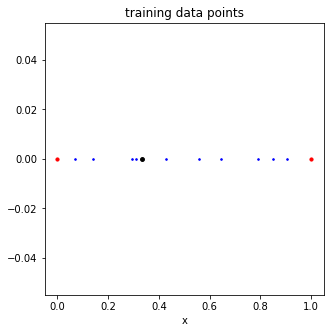

No. of trainable parameters = 8
Step 132: 
 training loss: 9.5503e-12
finished


In [14]:
# storages for errors, time instants, and IRK stages
relerr_loss = []
for char in char_id:
    
    torch.cuda.empty_cache()
    
    # NN structure
    if n_depth == 1:   # Shallow NN
        model = NeuralNet_Shallow( n_input , n_hidden , n_output ).double().to(device)
    else:   # Deep NN
        model = NeuralNet_Deep( n_input , n_hidden , n_output , n_depth ).double().to(device)

    # use Pytorch and functorch
    func_model, func_params = make_functional(model)
    
    # generate training data
    Xd_tr, Phid_tr, Fd_tr, Xb_tr, Ub_tr, Xg_tr, Fdng_tr, NL_tr, NL_sqrt_tr = generate_data(1, N_trd)
    tr_input  = DataInput(Xd=Xd_tr, Phid=Phid_tr, Fd=Fd_tr, Xb=Xb_tr, Ub=Ub_tr, Xg=Xg_tr, Fdng=Fdng_tr, 
                          NL=NL_tr, NL_sqrt=NL_sqrt_tr)
    
    # initialization of LM
    p_vec_old, dp_old, L_old, J_old = generate_initial_LM(func_params, NL_tr[1])
    print(f"No. of trainable parameters = {len(p_vec_old)}")
        
    # LM_setup
    mu = 10**(8)
    criterion = True
    LM_setup = LM_Setup( p_vec_o=p_vec_old , dp_o=dp_old , L_o=L_old , J_o=J_old , mu0=mu , criterion=criterion )

    # allocate loss
    lossval         = []
    lossval_dbg     = []
    lossval.append(1.)
    lossval_dbg.append([1.,1.,1.])

    # train the model by LM optimizer
    lossval, lossval_dbg, relerr_loss_char = train_PINNs_LM(func_params, LM_setup, tr_input, lossval, lossval_dbg)
    relerr_loss.append(relerr_loss_char)
    
    N_loss = len(lossval)
    lossval        = np.array(lossval).reshape(N_loss,1)
    lossval_dbg    = np.array(lossval_dbg)
    epochcol = np.linspace(1, N_loss, N_loss).reshape(N_loss,1)
    

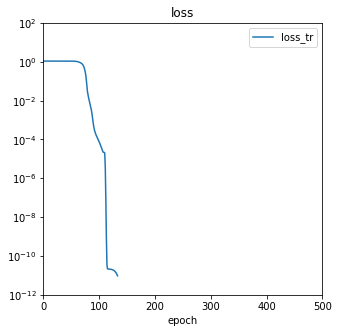

In [15]:
# plot evolution of loss
plt.figure(figsize = (5,5))

plt.semilogy(epochcol, lossval)
plt.legend(['loss_tr'], loc='upper right')
plt.title('loss')
plt.xlabel('epoch')
result = np.hstack( ( epochcol, lossval, lossval_dbg ) )
plt.xlim(0, 500)
plt.ylim(10**(-12), 10**(2))
plt.show()

### Testing data

No. of testing point: N_tsin (1000) + N_tsgm (1) = 1001


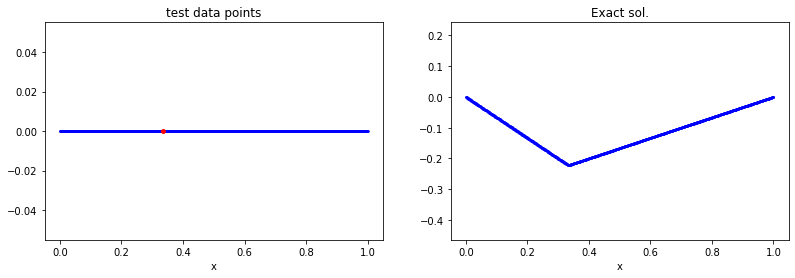

In [16]:
# No. of testing points
print(f'No. of testing point: N_tsin ({N_tsd_final}) + N_tsgm ({N_tsg_final}) = {N_tsd_final+N_tsg_final}')

# fixed pseudo random generator
#np.random.seed(777)

# testing points
sampling = lhs(n_input-1, N_tsd_final)
x = bda + (bdb-bda)*sampling[:,0:1]
z, zo  = levfun(0, x)
X_tsd = np.hstack( ( x , z ) )
X_tsd_torch = torch.tensor(X_tsd).double().to(device)

# exact solution of u
ref_u_tsd = exact_u(x, zo)
ref_u_tsd_infnorm = np.linalg.norm(ref_u_tsd, np.inf) 
ref_u_tsd_L2norm  = np.linalg.norm(ref_u_tsd, 2)


# generate interfacial testing points
x = gma 
z = np.zeros_like( x )
## normal vector 
Xnor_tsg = lvnorvec(x)
## normal derivative jump condition for level function
qdn_tsg = jump_lvdn(x)
## normal derivative jump condition for u
udn_tsg = jump_btadun(x)
## interface 
X_tsg = np.hstack( ( x , z ) )

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.3))

#===============
#  First subplot
#===============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1)
plt.scatter(X_tsd[:,0:1], 0*X_tsd[:,0:1], c = "b", s = 10, marker = ".") 
plt.scatter(X_tsg[0], 0*X_tsg[0], c = "r", s = 60, marker = ".")
plt.xlabel('x')
#plt.axis('equal')
plt.title('test data points')

#===============
# Second subplot
#===============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2)
plt.scatter(X_tsd[:,0:1], ref_u_tsd, c = "b", s = 10, marker = ".") 
plt.xlabel('x')
plt.title('Exact sol.')
plt.axis('equal')
plt.show()

In [17]:
pred_u = func_model(func_params, X_tsd_torch)[:].cpu().detach().numpy().flatten()
abserr = np.abs( pred_u - ref_u_tsd.flatten() )
err_inf = np.linalg.norm(abserr, np.inf)
err_L2  = np.linalg.norm(abserr, 2)
relerr_inf = err_inf / ref_u_tsd_infnorm
print(f"L_inf err.    : {err_inf:.4e}")
print(f"L_inf relerr. : {relerr_inf:.4e}")
relerr_L2  = err_L2 / ref_u_tsd_L2norm
print(f"L_2 err.    : {err_L2:.4e}")
print(f"L_2 relerr. : {relerr_L2:.4e}")

L_inf err.    : 7.6857e-08
L_inf relerr. : 3.4602e-07
L_2 err.    : 1.0994e-06
L_2 relerr. : 2.7097e-07


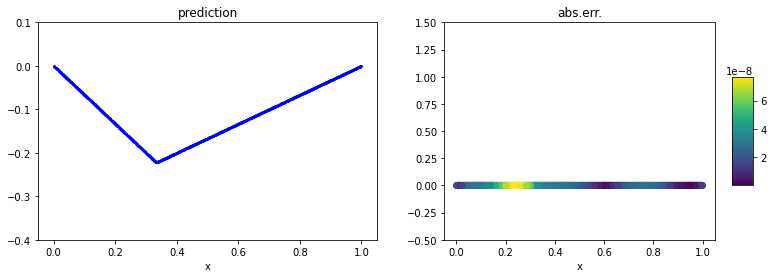

In [18]:
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.3))

#===============
#  First subplot
#===============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1)
plt.scatter(X_tsd[:,0:1], pred_u, c = "b", s = 10, marker = ".")
plt.xlabel('x')
plt.title('prediction')
plt.ylim(-0.4, 0.1)

# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 2)
surf = ax.scatter(X_tsd[:,0:1], abserr, c=abserr)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.xlabel('x')
plt.title('abs.err.')
plt.ylim(-0.5, 1.5)

plt.show()
